In [15]:
import os
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#NOTE: This is the index number to be manually changed for each index of the model
# I technically could automate it but why spend 5 hours automating it when I can spend 5 minutes manually doing it (if it was way more then it's different)
global INDEX_NUMBER
INDEX_NUMBER = 5

# Valid indicies for Ni (0,1,2) (3 total parameters)
# Valid indicies for Magnetar (0,1,2,3) (4 total parameters)
# Valid indicies for CSM (0,1,2,3,4,5) (6 total parameters)

#MinMaxScaler() is useful to normalize data where the default is  0 to 1 (aka. that is what we want)

#read the data (just read from the other file I really dont want to copy it over every time)
#make the network
#train the network
#predict the outcomes
#hyper parameterization

#This will read the data and put them into lists in memory
def read_data(filename1, filename2, filename3, ModelType="defualt_model"):
    
    x_list = []
    y_list = []

    if (ModelType == "Ni-Decay"):
        file1 = open(filename1, "r")

        for lines in file1:
            values = lines.split()

            x_list.append(values[3:])
            y_list.append(values[:3])

        file1.close()

        #Converts all the values to float
        for i in range(len(x_list)):
            for j in range(len(x_list[i])):
                x_list[i][j] = float(x_list[i][j])
        for i in range(len(y_list)):
            for j in range(len(y_list[i])):
                y_list[i][j] = float(y_list[i][j])

        x_list = np.array(x_list)
        y_list = np.array(y_list)

    elif (ModelType == "Magnetar"):
        file2 = open(filename2, "r")
        
        for lines in file2:
            values = lines.split()

            x_list.append(values[4:])
            y_list.append(values[:4])

        file2.close()
        
        for i in range(len(x_list)):
            for j in range(len(x_list[i])):
                x_list[i][j] = float(x_list[i][j])
        for i in range(len(y_list)):
            for j in range(len(y_list[i])):
                y_list[i][j] = float(y_list[i][j])

        x_list = np.array(x_list)
        y_list = np.array(y_list)

    elif (ModelType == "CSM"):
        file3 = open(filename3, "r")

        for lines in file3:
            values = lines.split()

            x_list.append(values[6:])
            y_list.append(values[:6])

        file3.close()
        
        for i in range(len(x_list)):
            for j in range(len(x_list[i])):
                x_list[i][j] = float(x_list[i][j])
        for i in range(len(y_list)):
            for j in range(len(y_list[i])):
                y_list[i][j] = float(y_list[i][j])  

        x_list = np.array(x_list)
        y_list = np.array(y_list)        
    
    else:
        raise ValueError(ModelType + " is not defined in the scope of this function. Only accepts \"Ni-Decay\" or \"Magnetar\"")
    
    return x_list, y_list

#Make sure the first arguement is Nickel Decay Model and second is Magnetar and the third reads the data for that Model
x_list, y_list = read_data(r'/home/quinn/Desktop/Shing-Chi/StatAnalysis/0LC_updated_data_sheet.data' ,
          r'/home/quinn/Desktop/Shing-Chi/StatAnalysis/M_updated_data_sheet.data', r"/home/quinn/Desktop/Shing-Chi/StatAnalysis/CSM_data_sheet.data", ModelType="CSM")

#This is basically here because if I go out of bounds I'll find out instantly
print(y_list[:,INDEX_NUMBER])

#NOTE: I am making the y_list in terms of log base 10
y_list = np.log10(y_list)

[3.16e+15 3.16e+12 1.00e+14 ... 3.16e+14 1.00e+14 1.00e+13]


In [16]:
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()
x_scale = scaler.fit_transform(x_list)
#y_scale = scaler.fit_transform(y_list)

#This is for numbers that are too large and need to be scaled
#This scales the larger velocity values
y_scale = scaler2.fit_transform(y_list[:,INDEX_NUMBER].reshape(1, -1).T)
# print(y_scale[:,0].ndim)
# print(y_scale.ndim)
# print(x_scale.ndim)

In [17]:
from sklearn.model_selection import GridSearchCV, cross_validate

#Create a training and testing framework from total data
#REMEMBER THAT I CHANGED TO Y_SCALE CHANGE THIS (an error will let me know)
x_train, x_test, y_train, y_test = train_test_split(x_scale, y_scale, test_size=0.20, random_state=42)

#Creates the regressor model
regressor = MLPRegressor(max_iter=5000)

# #This is the varaious tuning parameters that the tuning model will interate through and choose the one with the best score
parameters = {"hidden_layer_sizes": [(100,100), (200,200), (300,300), (100,100,100), (100,150,200), (200,200,200)], 
              #This was the old testing params [(33,66,100),(25,50,100),(100,150,200)],
              "activation": ["relu", "tanh"],
               "solver": ["adam"],
                "learning_rate": ["constant", "adaptive"] }

# #Creates a scoring dictionary
scoring = {'abs_error': 'neg_mean_absolute_error',
           'squared_error': 'neg_mean_squared_error',
           'r2':'r2'}

# #This creates the tuning model
tuning = GridSearchCV(regressor, parameters, scoring= "neg_mean_absolute_error")

# #Finds the best parameters
# #TODO CHANGE THIS BACK FOR OTHER MODELS [:,INDEX_NUMBER] (add this back to the end of y_train)
tuning_result = tuning.fit(x_train, y_train[:,0])

# #Assigns the best parameters to a dictionary called best_params
best_params = tuning_result.best_params_

# #Prints the best parameters from the tuning model to Output (basically a step away from writing to a file)
for keys,values in best_params.items():
    print("Key:",keys)
    print("Value:",values)

#Trains the MLPRRepressor Model with the best parameters stored in the dictionary from the tuning model
tuned_mlp = MLPRegressor(hidden_layer_sizes=best_params["hidden_layer_sizes"],
                         activation=best_params["activation"],
                         solver=best_params["solver"],
                         learning_rate=best_params["learning_rate"])


#Creates a dictionary with the scores from the model #NOTE: THIS BREAKS SOMETIMES
# scores = cross_validate(tuned_mlp, x_train, y_train[:,INDEX_NUMBER], scoring = scoring)


Key: activation
Value: relu
Key: hidden_layer_sizes
Value: (100, 150, 200)
Key: learning_rate
Value: constant
Key: solver
Value: adam


In [18]:
#Outputs the scores dictionary
# for keys,values in scores.items():
#     print("Key:",keys)
#     print("Value:",values)

#Trains the model that is using the best parameters
tuned_mlp.fit(x_train, y_train[:,0])
#Remember at this point all of the data has been scaled and needs to be unscaled after all the work is done 
y_pred = tuned_mlp.predict(x_test)

#Outputs predicted unscaled output
#print(y_pred)

In [19]:
from sklearn.metrics import mean_squared_error

mean_sqr_error = mean_squared_error(y_test[:,0], y_pred)

print("Mean_Square_Error =", mean_sqr_error)

Mean_Square_Error = 0.026216302112342504


[0.11908446042096649, 0.1847405150822736, 0.36505902862741196, 0.4979577551237898, 0.6604372097925126, 0.7792185717412136, 0.8242518226066254]
[0.1603913856753858, 0.1121693216047942, 0.1261999146210568, 0.11949116680504075, 0.11774204144960715, 0.14756222253661722, 0.18960444521144013]
[0.         0.16677097 0.33333333 0.50010431 0.66666667 0.83343764
 1.        ]


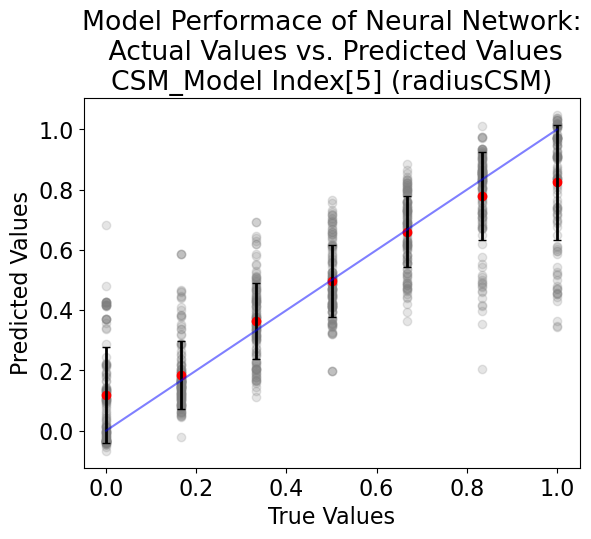

In [20]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.scatter(y_test[:,0], y_pred, alpha=.2, color="gray")
#ax.set_xscale("log")
#ax.set_yscale("log")
#TODO: Get percentage error.
# Get percent error for all data points and each list (X_TEST IS THE CORRECT VALUES COMPARE TO THAT!!!)
# then plot
# ax.errorbar(s) - reserach documentation

#TODO: MAKE A GLOBAL VARIABLE AT THE VERY TOP SO I CAN JUST CHANGE THAT ONE VARIABLE FOR THE INDEX OF THE MODEL SO I DONT HAVE TO CHANGE EVERY ONE

input_list = []


#Finds each unique input and appends it to a list
for i in y_test[:,0]:
    if i not in input_list:
        input_list.append(i)

#Sorts the input list
sorted_input_list = np.sort(input_list)

scatterPlotData = []
acceptedValues = []

#Remember this needs to change as more inputs from different models are used
for i in sorted_input_list:
    temp_list = []
    temp_list2 = []
    for j in range(len(y_test[:,0])):
        if (i == y_test[j,0]):
            #print("Input_List:", i,"| Index:", j, "| Value:", y_pred[j])
            temp_list.append(y_pred[j])
            temp_list2.append(y_test[j,0])
            
    scatterPlotData.append(temp_list)
    acceptedValues.append(temp_list2)

#Creates empty lists that should be a summary of all input values. (aka. the length of input_list)
mean_list = []
std_list = []

#Empty list for each and every value for each input
percentError_list = []

#Creating the variables to store the final total values
totalPercentError = 0
totalStandardDeviation = 0

#Gets the mean and the standard deviation of each input
for i in range(len(scatterPlotData)):
    #Appends to the mean list and the standard deviation list
    mean_list.append(np.mean(scatterPlotData[i]))
    std_list.append(np.std(scatterPlotData[i]))
    
    for j in range(len(scatterPlotData[i])):
        percentError_list.append( ( np.abs( (acceptedValues[i][j] - scatterPlotData[i][j]) / (scatterPlotData[i][j]) ) ) * 100 )


#Calculates the total Percent Error and Standard Deviation
totalPercentError = (np.mean(percentError_list))
totalStandardDeviation = (np.std(percentError_list))


#Error bars
ax.errorbar(sorted_input_list, mean_list, yerr=std_list, 
            ecolor = "black",
            color="red", 
            fmt="o",
            elinewidth=2,
            capsize=3,
            barsabove=True)
 

#Sets global font size
plt.rcParams['font.size'] = 16

#Remember to change the model as iterating through
ax.set_title("Model Performace of Neural Network:\n Actual Values vs. Predicted Values\n"+
             "CSM_Model Index["+str(INDEX_NUMBER)+"] (radiusCSM)")

ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")


x_guide = [sorted_input_list[0], sorted_input_list[-1]]
y_guide = [sorted_input_list[0], sorted_input_list[-1]]
# y_guide = [mean_list[0], mean_list[-1]]

plt.plot(x_guide, y_guide, color="blue", alpha=.5)

print(mean_list)
print(std_list)
print(sorted_input_list)

plt.show()

In [21]:
print(str("{:.2f}".format(totalPercentError))+"%")
print(str("{:.2f}".format(totalStandardDeviation)) + "%")

39.28%
51.23%


In [152]:
#TODO: Make sure you know what your doing before you execute this block just in case exiting below this comment
exit()

data_file = open("poster_data.data", "a")

#This is for the table (ignore until needed)
#Change this for each hidden_layer iteration (this is manual because this isn't techically a part of the program (just the presentation))
#data_file.write("Hidden_Layers: (100/100) -> " + str("{:.2f}".format(totalPercentError))+"% "+ "Percent Error -> " + str("{:.2f}".format(totalStandardDeviation)) +" Standard Deviation\n")

data_file.write("Magnetar Model Index["+str(INDEX_NUMBER)+"] -> ")
data_file.write(str("{:.2f}".format(totalPercentError)) + "% Percent Error -> " + str("{:.2f}".format(totalStandardDeviation)) + "% Standard Deviation\n\n")

# data_file.write(" -> " + str("{:.2f}".format(totalPercentError))+"% "+ "Percent Error -> " + str("{:.2f}".format(totalStandardDeviation)) +"% Standard Deviation\n")
# data_file.write("[Best Params] Activation: " + str(best_params["activation"]) + " -> Hidden Layer Sizes: " + str(best_params["hidden_layer_sizes"]))
# data_file.write(" -> Learning Rate: " + str(best_params["learning_rate"]) + " -> Solver: " + best_params["solver"] + "\n\n")

data_file.close()